In [9]:
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

get_ipython().run_line_magic('matplotlib', 'inline')

global polygon, area
def  display_img_grid(imgs, cols = 2, rows =3 , fsize=(10, 11),cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            imgs: List of np.arrays compatible with plt.imshow.
            cols (Default = 2): Number of columns in the figure.
            rows (Default = 3): Number of rows in the figure.
            figsize (Default 10,11): fisure size.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=fsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap = cmap)
        plt.xticks([])
        plt.yticks([])   
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

# function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the image with calibration corners
def calibrate_camera(img,hPt,vPt,objp):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (hPt,vPt), None)
    #defining a blank mask to start with
    cal_img = np.copy(img) 
      # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        cal_img = cv2.drawChessboardCorners(cal_img, (hPt,vPt), corners, ret)
    return cal_img
# undistort image using camera calibration matrix
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist




# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    #1 Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    #2 Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    #3 Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    #4 Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #5 Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #6 Return this mask as your sxbinary image

    return sxbinary
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output



def threshold_Channel(channel,thresh):
    retval, binary = cv2.threshold(channel.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

# Perspective transform undistort image
# return unwarped perspective transformed image
def transform(undist,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped



def chennel_extraction(img):
    img = np.copy(img)
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1)|(s_binary == 1) | (b_binary == 1)] = 1
    return combined_binary

class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                #plt.plot(histogram)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

# Pipeline for finding Lanes
def process_frame(image):
    img_size = (image.shape[1], image.shape[0])
    undist = undistort(np.copy(image))
     # Perform perspective transform
    offset = 0
   # src = np.float32([[490, 482],[810, 482],
                   #   [1250, 720],[0, 720]])
   # dst = np.float32([[0, 0], [1280, 0], 
                   # [1250, 720],[40, 720]])
    unwarp = transform(undist, src, dst,img_size)
  
    #combined_binary = chennel_extraction(unwarp)
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(unwarp, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(unwarp, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    # Sort detected pixels based on the yvals
    #leftx, lefty = Left.sort_vals(leftx, lefty)
    #maxLx = leftx[-1]
    #print("bef lx ",leftx)
    #print("mL",maxLx)
    #t_min=maxLx-50
    #t_max=maxLx+50
    #newleftx = np.copy(leftx)
    #leftx[(leftx <= t_min) | (leftx >= t_max)] = maxLx
    #print("af lx ",newleftx)
     # Sort right lane pixels
    #rightx, righty = Right.sort_vals(rightx, righty)
    #maxRx = rightx[-1]
    #print("bef rx ",rightx)
    #print("mL",maxRx)
    #t_min=maxRx-50
    #t_max=maxRx+50
    #newrightx = np.copy(rightx)
    #rightx[(rightx <= t_min) | (rightx >= t_max)] = maxRx
    #print("af lx ",newrightx)
   
  

    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    Left.X = leftx
    Left.Y = lefty
  
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
   
   
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    #print(left_fitx) 
    #print(right_fitx)
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
  
        
    Left.count += 1
    return result
    

20
20


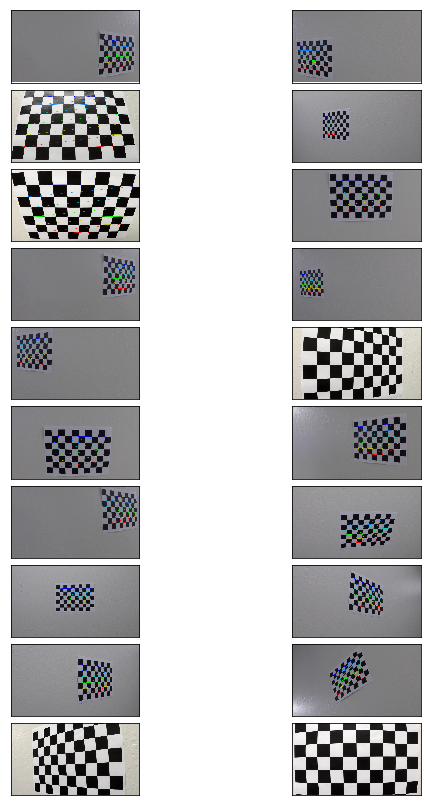

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)# prepa 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

org_imgs = []
#Reading all the jpg images from test_images folder and display the same in grid
org_imgs = [plt.imread(img) for img in glob.glob('./camera_cal/calibration*.jpg')]
print(len(org_imgs))

unwrapped_imgs= []

for pos,img in enumerate(org_imgs):
    unwrapped_imgs.append(calibrate_camera(img,9,6,objp))
    
print(len(unwrapped_imgs))
display_img_grid(unwrapped_imgs,2,10)



Text(0.5,1,'Undistorted Image')

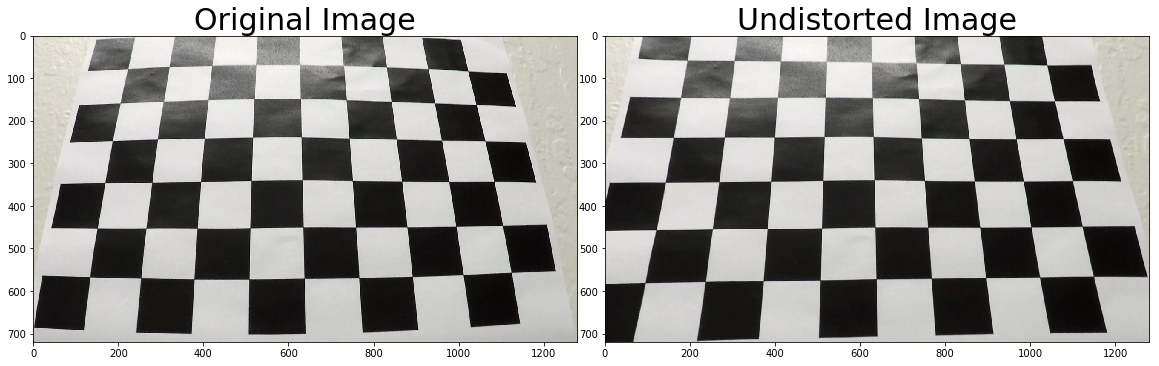

In [3]:
# Test undistortion on an image
img_size = (org_imgs[2].shape[1], org_imgs[2].shape[2])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undst = undistort(org_imgs[2])

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(org_imgs[2])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

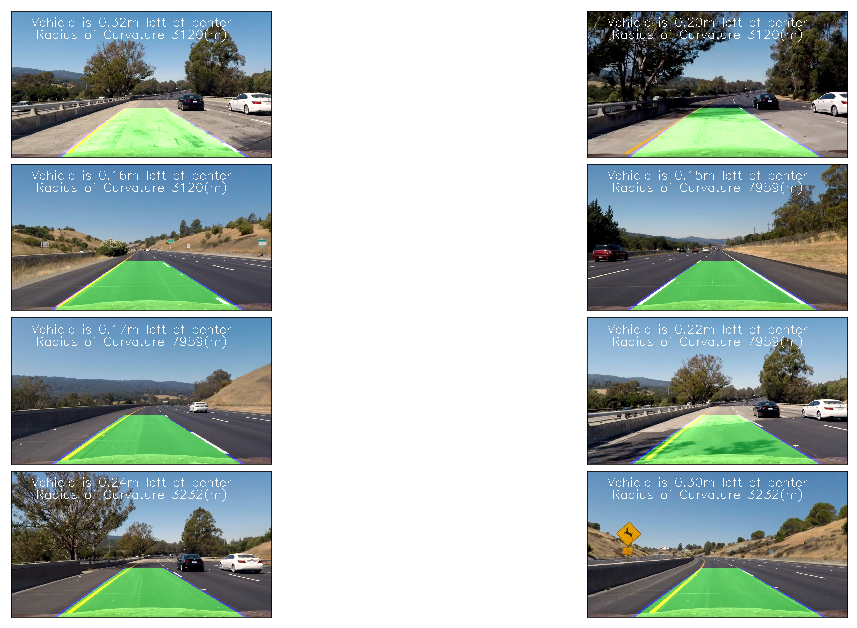

In [10]:

#Reading all the jpg images from test_images folder and display the same in grid
org_imgs = [plt.imread(img) for img in glob.glob('./test_images/*.jpg')]
img_size = (org_imgs[0].shape[1], org_imgs[0].shape[0])
Left =  Line()
Right =  Line()

src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])

result_img=[]

for pos,img in enumerate(org_imgs):
    result_img.append(process_frame(img))
display_img_grid(result_img,2,len(result_img),(16, 17))  

In [11]:

Left =  Line()
Right =  Line()

src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
video_output = './project_out_video.mp4'
#Apply the below pipline steps for each from of the video
clip1 = VideoFileClip('./project_video.mp4')#.subclip(0,5)

white_clip = clip1.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./project_out_video.mp4
[MoviePy] Writing video ./project_out_video.mp4


100%|█████████▉| 1260/1261 [08:31<00:00,  2.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_out_video.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [13]:
Left =  Line()
Right =  Line()

video_output = './challenge_out_video.mp4'
#Apply the below pipline steps for each from of the video
clip1 = VideoFileClip('./challenge_video.mp4')

white_clip = clip1.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./challenge_out_video.mp4
[MoviePy] Writing video ./challenge_out_video.mp4


100%|██████████| 485/485 [02:40<00:00,  2.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_out_video.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [15]:
Left =  Line()
Right =  Line()

video_output = './harder_challenge_out_video.mp4'
#Apply the below pipline steps for each from of the video
clip1 = VideoFileClip('./harder_challenge_video.mp4')

white_clip = clip1.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./harder_challenge_out_video.mp4
[MoviePy] Writing video ./harder_challenge_out_video.mp4


100%|█████████▉| 1199/1200 [10:32<00:00,  1.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_out_video.mp4 



In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))